# Table of Contents

1. [Problem Statement](#pstatement)
2. [Data Loading and Preprocessing](#dload)
3. [Data Spliting into train, valid, and test](#dsplit)
4. [Data Augmentation](#daugment)
5. [Model Building](#mbuild)
6. [Model Training](#mtrain)
7. [Model Testing](#mtest)
8. [Performance Visualization](#pvis)
9. [Performance Measures](#pmeasures)

# Problem Statement<a id='pstatement'><\a>
To implement an image degmentation pipeline using CNNs to get sementic understanding of the images.


**Monuseg dataset** (available [here](https://monuseg.grand-challenge.org/Data/)) is downloaded and the ground truth segmentation masks are created. The dataset can be either obtained from the instructor or can be downloaded from [this](https://drive.google.com/drive/folders/1hnHjxFb52BdhxkcV_N7MdWLdagzXHzmq?usp=sharing) Google Drive link.

In [0]:
#Imports the print function from newer versions of python
from __future__ import print_function

from glob import glob
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [0]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Input, concatenate
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [0]:
def load(image_path): #Load an image from a file path
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)

def display(image, title=None): # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(image)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

# Data Loading and Preprocessing<a id='dload'><\a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip "/content/drive/My Drive/MonuSeg-dataset"

Archive:  /content/drive/My Drive/MonuSeg-dataset.zip
replace MonuSeg/Test/GroundTruth/TCGA-AC-A2FO-01A-01-TS1_bin_mask.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
files_path = "./MonuSeg"

loading..


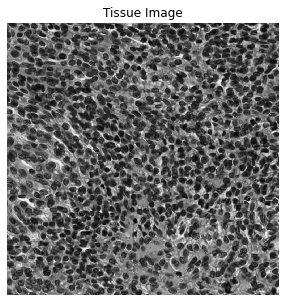

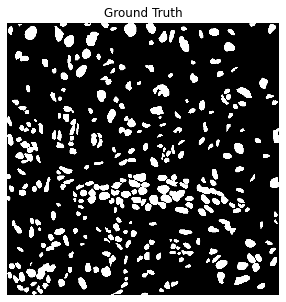

Train data of size: (30, 1024, 1024, 1) loaded!


In [0]:
# load training set
X_train, Y_train = [], []

print ("loading..")

for image_path in glob(files_path+'/Training/TissueImages/*'):
    X_train.append(cv2.resize(load(image_path), (1024, 1024)))
display(X_train[-1], "Tissue Image") # display the last read image

for image_path in glob(files_path+'/Training/GroundTruth/*'):
    Y_train.append(cv2.resize(load(image_path), (1024, 1024)))
display(Y_train[-1], "Ground Truth") # display the last read image

X_train = np.array(X_train, dtype="float") / 255.0
Y_train = np.array(Y_train, dtype="float") / 255.0

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], 1))

print ("Train data of size: {} loaded!".format(X_train.shape))

loading..


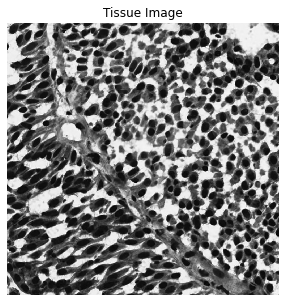

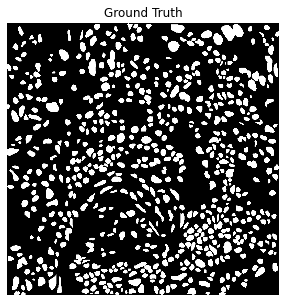

Test data of size: (14, 1024, 1024, 1) loaded!


In [0]:
# load testing set
X_test, Y_test = [], []

print ("loading..")

for image_path in glob(files_path+'/Test/TissueImages/*'):
    X_test.append(cv2.resize(load(image_path), (1024, 1024)))
display(X_test[-1], "Tissue Image") # display the last read image

for image_path in glob(files_path+'/Test/GroundTruth/*'):
    Y_test.append(cv2.resize(load(image_path), (1024, 1024)))
display(Y_test[-1], "Ground Truth") # display the last read image

X_test = np.array(X_test, dtype="float") / 255.0
Y_test = np.array(Y_test, dtype="float") / 255.0

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], 1))

print ("Test data of size: {} loaded!".format(X_test.shape))

# Data Spliting<a id='dsplit'><\a>
Split the training data into training, and validation sets.

In [0]:
# split the training set to training and validation sets with the ratio 80:20
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [0]:
print ("X_train: ", np.shape(X_train), "\nY_train: ", np.shape(Y_train))
print ("X_valid: ", np.shape(X_valid), "\nY_valid: ", np.shape(Y_valid))
print ("X_test: ", np.shape(X_test), "\nY_test: ", np.shape(Y_test))

X_train:  (24, 1024, 1024, 1) 
Y_train:  (24, 1024, 1024, 1)
X_valid:  (6, 1024, 1024, 1) 
Y_valid:  (6, 1024, 1024, 1)
X_test:  (14, 1024, 1024, 1) 
Y_test:  (14, 1024, 1024, 1)


# Data Augmentation<a id='daugment'><\a>
Apply different transformations to the data to increase its diversity.

In [0]:
BATCHSIZE = 3 # batch size

In [0]:
# 'augmentor' is the image data generator for data augmentation
augmentor = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                               height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                               horizontal_flip=True, fill_mode="nearest")

# 'augmented_train_data' is the augmented training set
augmented_train_data = augmentor.flow(X_train, Y_train, batch_size=BATCHSIZE)

# 'augmented_valid_data' is the augmented validation set
augmented_valid_data = augmentor.flow(X_valid, Y_valid, batch_size=BATCHSIZE)

# Model Building<a id='mbuild'><\a>

![SegNet Architecture](https://vasanashwin.github.io/retrospect/images/unet.png)

In [0]:
class UNet:
    def __init__(self):
        pass

    def encoder_block(self, input_layer, depth, dropout):
        output_layer = Conv2D(depth, (3, 3), activation='relu', padding="same")(input_layer)
        output_layer = Conv2D(depth, (3, 3), activation='relu', padding="same")(output_layer)
        output_layer = MaxPooling2D(pool_size=(2, 2))(output_layer)
        output_layer = Dropout(dropout)(output_layer)
        return output_layer

    def encoder(self, input_layer, depth):
        block1 = self.encoder_block(input_layer, depth, dropout=0.25)
        block2 = self.encoder_block(block1, depth*2, dropout=0.25)
        block3 = self.encoder_block(block2, depth*4, dropout=0.25)
        block4 = self.encoder_block(block3, depth*8, dropout=0.25)
        return block1, block2, block3, block4

    def decoder_block(self, input_layer, depth, dropout):
        output_layer = Conv2D(depth, (3, 3), activation='relu', padding="same")(input_layer)
        output_layer = Conv2D(depth, (3, 3), activation='relu', padding="same")(output_layer)
        output_layer = Dropout(dropout)(output_layer)
        return output_layer

    def decoder(self, block1, block2, block3, block4, block5, depth):
        upconvolved = Conv2DTranspose(depth, (3, 3), strides = (2, 2), padding = 'same')(block5)
        concatenated = concatenate([block4, upconvolved])
        output_layer = self.decoder_block(concatenated, depth, dropout=0.25)

        upconvolved = Conv2DTranspose(depth, (3, 3), strides = (2, 2), padding = 'same')(output_layer)
        concatenated = concatenate([block3, upconvolved])
        output_layer = self.decoder_block(concatenated, depth//2, dropout=0.25)

        upconvolved = Conv2DTranspose(depth, (3, 3), strides = (2, 2), padding = 'same')(output_layer)
        concatenated = concatenate([block2, upconvolved])
        output_layer = self.decoder_block(concatenated, depth//4, dropout=0.25)

        upconvolved = Conv2DTranspose(depth, (3, 3), strides = (2, 2), padding = 'same')(output_layer)
        concatenated = concatenate([block1, upconvolved])
        output_layer = self.decoder_block(concatenated, depth//8, dropout=0.25)

        return output_layer

    def UNet(self, input_shape):
        depth = 2
        input_layer = Input(shape=input_shape)

        block1, block2, block3, block4 = self.encoder(input_layer, depth)

        block5 = MaxPooling2D(pool_size=(2, 2))(block4)
        block5 = Conv2D(depth*16, (3, 3), activation='relu', padding="same")(block5)
        block5 = Conv2D(depth*16, (3, 3), activation='relu', padding="same")(block5)

        decoded = self.decoder(block1, block2, block3, block4, block5, depth*8)

        upconvolved = Conv2DTranspose(depth, (3, 3), strides = (2, 2), padding = 'same')(decoded)

        output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding="same")(upconvolved)

        model = Model(input_layer, output_layer)
        return model

model = UNet().UNet(input_shape=(X_train[0].shape))

In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 1024, 1024, 2 20          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 1024, 1024, 2 38          conv2d_148[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 512, 512, 2)  0           conv2d_149[0][0]                 
____________________________________________________________________________________________

# Model Training<a id='mtrain'><\a>

In [0]:
INIT_LR = 0.01 # initial learning rate
EPOCHS = 10 # number of epocks
 
# compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
 
# train the network using augmented data
#H = model.fit_generator(augmented_train_data, validation_data=augmented_valid_data,
#                        steps_per_epoch=len(X_train)//BATCHSIZE, epochs=EPOCHS)

# train the network
H = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
              validation_steps=len(X_valid)//BATCHSIZE,
              steps_per_epoch=len(X_train)//BATCHSIZE, epochs=EPOCHS)

Train on 24 samples, validate on 6 samples
Epoch 1/10
8/8 [==============================] - 9s 1s/step - loss: nan - acc: 0.2828 - val_loss: nan - val_acc: 0.1873
Epoch 2/10
8/8 [==============================] - 4s 489ms/step - loss: nan - acc: 0.2469 - val_loss: nan - val_acc: 0.1873
Epoch 3/10
8/8 [==============================] - 4s 487ms/step - loss: nan - acc: 0.2469 - val_loss: nan - val_acc: 0.1873
Epoch 4/10
8/8 [==============================] - 4s 488ms/step - loss: nan - acc: 0.2469 - val_loss: nan - val_acc: 0.1873
Epoch 5/10
8/8 [==============================] - 4s 486ms/step - loss: nan - acc: 0.2469 - val_loss: nan - val_acc: 0.1873
Epoch 6/10
8/8 [==============================] - 4s 489ms/step - loss: nan - acc: 0.2469 - val_loss: nan - val_acc: 0.1873
Epoch 7/10
8/8 [==============================] - 4s 486ms/step - loss: nan - acc: 0.2469 - val_loss: nan - val_acc: 0.1873
Epoch 8/10
8/8 [==============================] - 4s 488ms/step - loss: nan - acc: 0.2469 - 

# Model Testing<a id='mtest'><\a>

In [0]:
# evaluate the network
predictions = model.predict(X_test, batch_size=BATCHSIZE)

# Performance Visualization<a id='pvis'><\a>

In [0]:
# plot the training and validation losses
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, H.history["loss"], label="Training")
plt.plot(N, H.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("segnet_basic_loss_plot.png")
plt.show()

In [0]:
# plot the training and validation accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["acc"], label="Training")
plt.plot(N, H.history["val_acc"], label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("segnet_basic_accuracy_plot.png")
plt.show()

In [0]:
# save the model for future use or deployment
model.save("segnet_basic.model")

# Performance Measures<a id='pmeasures'><\a>

## Accuracy

In [0]:
print ("Accuracy:", accuracy_score(Y_test, predictions)*100)

##F1 Score

##Dice Score